In [1]:
module Ising

struct Board{S, T, U}
    state::S
    β::T
    prob::U
end

function randboard(; n = 200, β = log(1 + √2)/2)
    state = rand(Int8.((-1, 1)), n, n)
    prob = Tuple(exp(-2k*β) for k in -4:4)
    Board(state, β, prob)
end

using Plots
@recipe function f(board::Board)
    seriestype := :heatmap
    board.state
end

P(i, m) = ifelse(i == m, 1, i + 1)
Q(i, m) = ifelse(i == 1, m, i - 1)

struct SingleThread end
function update!(board::Board, niters, ::SingleThread)
    s, prob = board.state, board.prob
    m, n = size(s)
    for _ in 1:niters
        for j in 1:n
            @inbounds for i in 1:m
                sij = s[i, j]
                k = sij * (s[Q(i, m), j] + s[P(i, m), j] + s[i, Q(j, n)] + s[i, P(j, n)])
                s[i, j] -= 2(rand() < prob[k + 5]) * sij
            end
        end
    end
end

struct MultiThread end
function update!(board::Board, niters, ::MultiThread)
    s, prob = board.state, board.prob
    m, n = size(s)
    for _ in 1:niters, j0 in 1:2
        Threads.@threads for j in j0:2:n
            @inbounds for i in 1:m
                sij = s[i, j]
                k = sij * (s[Q(i, m), j] + s[P(i, m), j] + s[i, Q(j, n)] + s[i, P(j, n)])
                s[i, j] -= 2(rand() < prob[k + 5]) * sij
            end
        end
    end
end

update!(board::Board, niters) = update!(board::Board, niters, MultiThread())

end

using Plots
default(size=(240, 240), colorbar=false, ticks=false, axis=false)

using BenchmarkTools

println("Julia v", VERSION)
println("nthreads() = ", Threads.nthreads())

Julia v1.8.0-DEV.310
nthreads() = 12


 26.662056 seconds (286.49 M allocations: 12.347 GiB, 7.08% gc time, 8.62% compilation time)


┌ Info: Saved animation to 
│   fn = D:\OneDrive\public\0015\ising_singlethread.gif
└ @ Plots D:\.julia\packages\Plots\Awg62\src\animation.jl:104


Plots.AnimatedGif("D:\\OneDrive\\public\\0015\\ising_singlethread.gif")
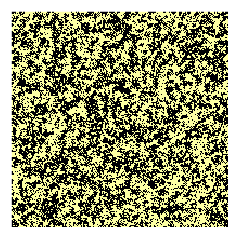

In [2]:
board = Ising.randboard(n = 200)
@time anim = @animate for _ in 1:400
    Ising.update!(board, 1, Ising.SingleThread())
    plot(board)
end
gif(anim, "ising_singlethread.gif"; fps = 20)

 15.854123 seconds (260.84 M allocations: 11.027 GiB, 9.48% gc time, 0.83% compilation time)


┌ Info: Saved animation to 
│   fn = D:\OneDrive\public\0015\ising_multithread.gif
└ @ Plots D:\.julia\packages\Plots\Awg62\src\animation.jl:104


Plots.AnimatedGif("D:\\OneDrive\\public\\0015\\ising_multithread.gif")
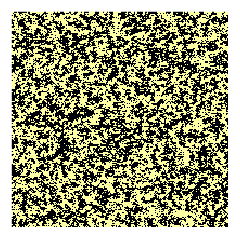

In [3]:
board = Ising.randboard(n = 200)
@time anim = @animate for _ in 1:400
    Ising.update!(board, 1, Ising.MultiThread())
    heatmap(board)
end
gif(anim, "ising_multithread.gif"; fps = 20)

In [4]:
@show Threads.nthreads()
board = Ising.randboard(n = 200)
print("SingleThread:")
@btime Ising.update!($board, 1, $(Ising.SingleThread()))
print("MultiThread:  ")
@btime Ising.update!($board, 1, $(Ising.MultiThread()))

Threads.nthreads() = 12
SingleThread:  220.700 μs (0 allocations: 0 bytes)
MultiThread:    35.900 μs (121 allocations: 14.69 KiB)


In [5]:
@show Threads.nthreads()
board = Ising.randboard(n = 632)
print("SingleThread:")
@btime Ising.update!($board, 1, $(Ising.SingleThread()))
print("MultiThread:   ")
@btime Ising.update!($board, 1, $(Ising.MultiThread()))

Threads.nthreads() = 12
SingleThread:  2.214 ms (0 allocations: 0 bytes)
MultiThread:     243.000 μs (121 allocations: 14.69 KiB)
